## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

###  1. import dependency libraries.

In [1]:
import glob
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def show_images_by_side(l_img, r_img, l_label, r_label):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(l_img)
    ax1.set_title(l_label, fontsize=50)
    ax2.imshow(r_img)
    ax2.set_title(r_label, fontsize=50)

### 2. compute the camera calibration using chessboard images.

In [3]:
def get_intrinsics(image_glob, grid_x=9, grid_y=6):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,9,0)
    objp = np.zeros((grid_x*grid_y,3), np.float32)
    objp[:,:2] = np.mgrid[0:grid_y,0:grid_x].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # search for chessboard corners
    for fname in glob.glob(image_glob):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (grid_y, grid_x), None)

        # if found, add object points, image points
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, k_mtx, dist, rvecs, tvecs = \
        cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return k_mtx, dist

# compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
K, D = get_intrinsics('./camera_cal/calibration*.jpg')

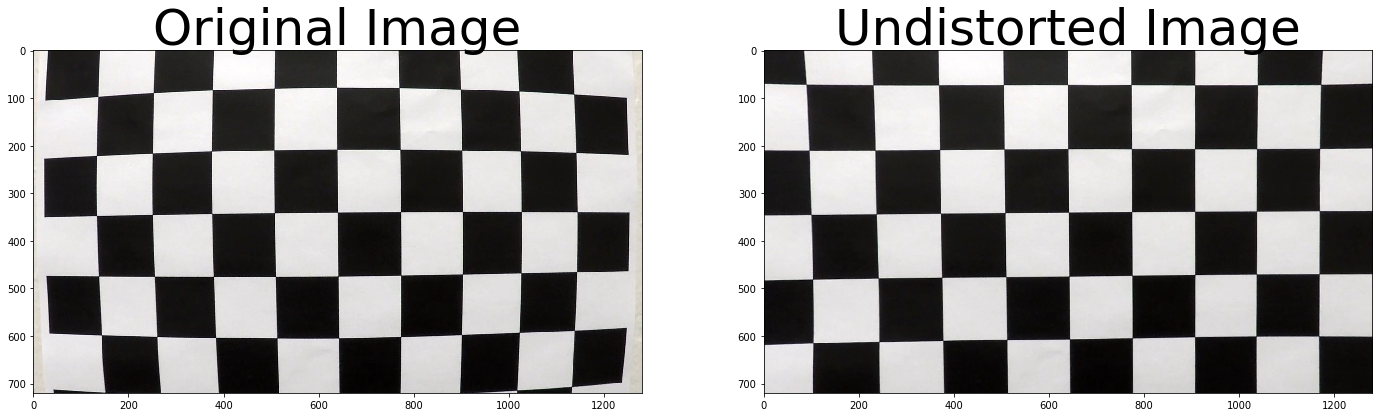

In [4]:
# apply a distortion correction to raw images.
origin_calibimg = mpimg.imread('./camera_cal/calibration1.jpg')
undist_calibimg = cv2.undistort(origin_calibimg, K, D, None, K)

show_images_by_side(origin_calibimg, undist_calibimg, 'Original Image', 'Undistorted Image')

## 3. color transforms, gradients and create a thresholded binary image. 

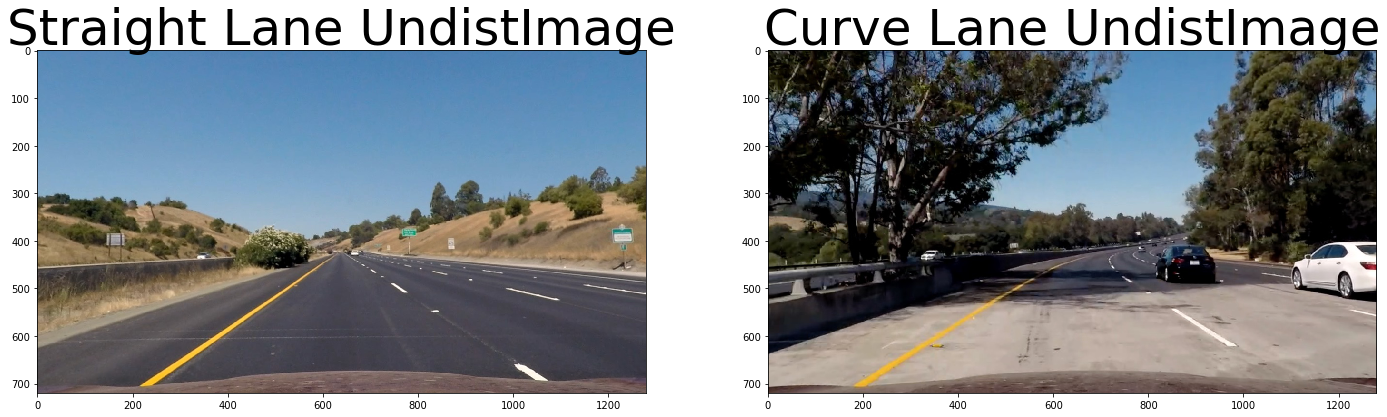

In [5]:
straight_imgpath = './test_images/straight_lines1.jpg'
straight_img = mpimg.imread(straight_imgpath)
undist_straightimg = cv2.undistort(straight_img, K, D, None, K)

curve_imgpath = './test_images/test5.jpg'
curve_img = mpimg.imread(curve_imgpath)
undist_curveimg = cv2.undistort(curve_img, K, D, None, K)

show_images_by_side(undist_straightimg, undist_curveimg, 'Straight Lane UndistImage', 'Curve Lane UndistImage')

In [6]:
def get_binary_images(image, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(image)
    
    # convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    
    # absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # threshold x gradient and color channel
    binary_image = np.zeros_like(scaled_sobel)
    binary_image[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1]) | 
             (s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    return binary_image

### 3.1 an example of a binary image result.

Text(0.5,1,'Binary StraightImage')

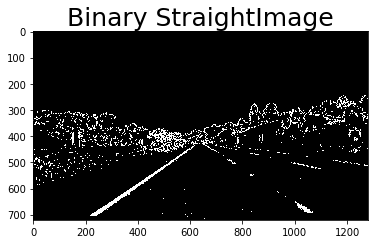

In [7]:
# use color transforms, gradients, etc., to create a thresholded binary image.
binary_straightimg = get_binary_images(undist_straightimg)

plt.imshow(binary_straightimg, cmap='gray')
plt.title('Binary StraightImage', fontsize=25)

## 4. perspective transform.

In [8]:
# apply a perspective transform to rectify binary image ("birds-eye view").
side_margin = 250
img_h, img_w = binary_straightimg.shape

src_corners = np.float32([
              [710, 467],
              [1108,719],
              [207, 719],
              [570, 467]])
dst_corners = np.float32([
              [img_w-side_margin, 0],
              [img_w-side_margin, img_h-1],
              [side_margin, img_h-1],
              [side_margin, 0]])

M = cv2.getPerspectiveTransform(src_corners, dst_corners)

### 4.1 an example of a transformed image.

Text(0.5,1,'Birds-Eye View')

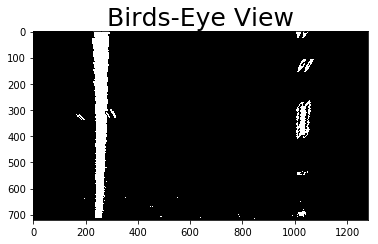

In [9]:
binary_straight_warped = cv2.warpPerspective(binary_straightimg, M, (img_w, img_h) )

plt.imshow(binary_straight_warped, cmap='gray')
plt.title('Birds-Eye View', fontsize=25)

## 5. the method identified lane-line pixels and fit their positions with a polynomial.

Text(0.5,1,'Binary CurveImage')

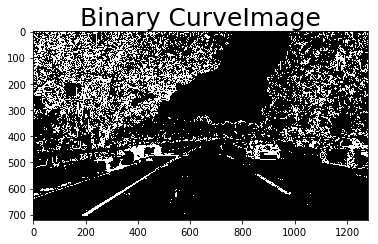

In [10]:
binary_curveimg = get_binary_images(undist_curveimg)

plt.imshow(binary_curveimg, cmap='gray')
plt.title('Binary CurveImage', fontsize=25)

Text(0.5,1,'Birds-Eye View')

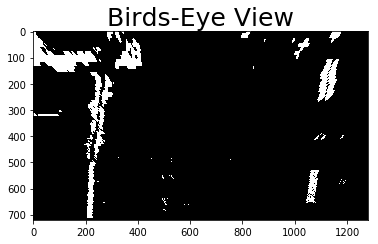

In [11]:
binary_curve_warped = cv2.warpPerspective(binary_curveimg, M, (img_w, img_h) )

plt.imshow(binary_curve_warped, cmap='gray')
plt.title('Birds-Eye View', fontsize=25)

In [12]:
# define conversions in x and y from pixels space to meters
ym_per_pix = 30/img_h
xm_per_pix = 3.7/(img_w-2*side_margin)

In [13]:
def fit_polynomial(binary_warped, nwindows=9, margin=100, minpix=50):
    """
    nwindows: the number of sliding windows 
    margin: the width of the windows +/- margin
    minpix: minimum number of pixels found to recenter window
    """
    # take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # find the peak of the left and right halves of the histogram.
    # these will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        # identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        # define the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # if you found > minpix pixels, recenter next window.
        # (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # avoids an error if the above is not implemented fully
        pass

    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    return left_fit, right_fit

# detect lane pixels and fit to find the lane boundary.
left_fit, right_fit = fit_polynomial(binary_curve_warped, margin=200)

In [14]:
def search_around_poly(binary_warped, left_fit, right_fit, margin=100):
    """
    margin: the width of the margin around the previous polynomial to search
    """
    # grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # set the area of search based on activated x-values
    leftlane_points = left_fit[0]*((nonzeroy*ym_per_pix)**2) + left_fit[1]*(nonzeroy*ym_per_pix) + left_fit[2]
    left_lane_inds = (
        (nonzerox*xm_per_pix > (leftlane_points - margin*xm_per_pix)) & 
        (nonzerox*xm_per_pix < (leftlane_points + margin*xm_per_pix)) )
    
    rightlane_points = right_fit[0]*((nonzeroy*ym_per_pix)**2) + right_fit[1]*(nonzeroy*ym_per_pix) + right_fit[2]
    right_lane_inds = (
        (nonzerox*xm_per_pix > (rightlane_points - margin*xm_per_pix)) & 
        (nonzerox*xm_per_pix < (rightlane_points + margin*xm_per_pix)) )
    
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # fit new polynomials
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    return left_fit, right_fit

left_fit, right_fit = search_around_poly(binary_curve_warped, left_fit, right_fit)

## 6. calculates the radius of curvature of the lane and the position of the vehicle with respect to center.

In [15]:
def measure_curvature_real(y_eval, left_fit, right_fit):
    left_curverad = (1+(2*left_fit[0]*y_eval*ym_per_pix+left_fit[1])**2)**1.5/np.abs(2*left_fit[0])
    right_curverad = (1+(2*right_fit[0]*y_eval*ym_per_pix+right_fit[1])**2)**1.5/np.abs(2*right_fit[0])
    return left_curverad, right_curverad

# determine the curvature of the lane and vehicle position with respect to center.
left_curverad, right_curverad = measure_curvature_real(img_h-1, left_fit, right_fit)
print("left radius of curvature: ", left_curverad)
print("right radius of curvature: ", right_curverad)

left radius of curvature:  1020.68499038
right radius of curvature:  454.936622583


## 7. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

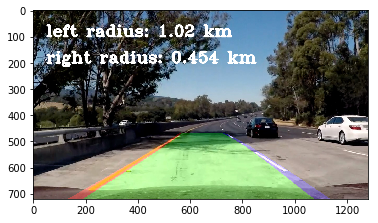

In [16]:
def display_lane_boundaries(image, left_fit, right_fit, left_curverad, right_curverad):
    # create an image to draw the lanes
    warp_zero = np.zeros(image.shape[:2]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # recast the x and y points into usable format for cv2.fillPoly().
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    
    # generate x and y values for plotting    
    left_fitx = (left_fit[0]*(ploty*ym_per_pix)**2 + left_fit[1]*(ploty*ym_per_pix) + left_fit[2]) / xm_per_pix
    right_fitx = (right_fit[0]*(ploty*ym_per_pix)**2 + right_fit[1]*(ploty*ym_per_pix) + right_fit[2]) / xm_per_pix

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))], dtype=np.int32)
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))], dtype=np.int32)
    pts = np.hstack((pts_left, pts_right))

    # draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    cv2.polylines(color_warp, pts_left, False, color=(255, 0, 0), thickness=50)
    cv2.polylines(color_warp, pts_right, False, color=(0, 0, 255), thickness=50)

    # warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = np.linalg.inv(M)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_w, img_h)) 
    
    # combine the result with the original image
    result = cv2.addWeighted(curve_img, 1, newwarp, 0.3, 0)

    # put text about curve radius.
    left_str = "left radius: " + str(int(left_curverad)/1000) + " km"
    right_str = "right radius: " + str(int(right_curverad)/1000) + " km"
    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(result, left_str, (50,100), font, 2, (255,255,255), 5, cv2.LINE_AA)
    cv2.putText(result, right_str, (50,200), font, 2, (255,255,255), 5, cv2.LINE_AA)
    plt.imshow(result)

# warp the detected lane boundaries back onto the original image.
# output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
display_lane_boundaries(curve_img, left_fit, right_fit, left_curverad, right_curverad) 

## 8. create a pipeline library for finding lanes, and execute pipeline to all test images.

In [17]:
import os
from advanced_lane import Line, Camera, lane_boundaries_image

def lane_finding_pipeline(image, camera, l_line, r_line):
    undist = camera.undistort(image)
    binary = camera.binarize(undist)
    warped = camera.perspective(binary)
    
    l_line.detect(warped)
    l_curve = l_line.calc_curvature(image.shape[0]-1)
    
    r_line.detect(warped)
    r_curve = r_line.calc_curvature(image.shape[0]-1)

    l_ok = l_line.check(r_line)
    r_ok = r_line.check(l_line)
    #if not(l_ok) or not(r_ok):
    #    print("recalculate line.")
    
    result = lane_boundaries_image(undist, camera, l_line, r_line)
    return result

### 8.1 Test Images

In [18]:
# Camera Object
img_h, img_w = curve_img.shape[:2]
side_margin=250
src_corners = np.float32([
              [710, 467],
              [1108,719],
              [207, 719],
              [570, 467]])

camera = Camera(img_h, img_w, src_corners, side_margin=side_margin)
camera.calibrate('./camera_cal/calibration*.jpg')

# Line Object
ym_per_pix = 30/img_h
xm_per_pix = 3.7/(img_w-2*side_margin)

l_line = Line(ym_per_pix, xm_per_pix)
r_line = Line(ym_per_pix, xm_per_pix, right=True)

# execute pipeline
image_list = glob.glob("./test_images/test*.jpg")
image_list.sort()
for fname in image_list:
    print(fname)
    image = mpimg.imread(fname)
    result = lane_finding_pipeline(image, camera, l_line, r_line)
    
    # write image.
    output_path = "./output_images/" + os.path.basename(fname)
    mpimg.imsave(output_path, result)

./test_images/test1.jpg
./test_images/test2.jpg
./test_images/test3.jpg
./test_images/test4.jpg
./test_images/test5.jpg
./test_images/test6.jpg


### 8.2 Project Movie

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
def process_image(image):
    result = lane_finding_pipeline(image, camera, l_line, r_line)
    return result

In [21]:
output_video = 'output_images/project_video.mp4'
orig_clip = VideoFileClip("./project_video.mp4")
lane_clip = orig_clip.fl_image(process_image)
%time lane_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [04:50<00:00,  4.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 2min 11s, sys: 27.6 s, total: 2min 39s
Wall time: 4min 53s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))